In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [67]:
class MnistCustomDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.transform = transform
    self.data = pd.read_csv(csv_file)
    self.targets = torch.tensor(self.data.loc[:, "label"].to_numpy())
  
  def __getitem__(self, index):
    sample = self.data.loc[index][1:].to_numpy(dtype=np.float32).reshape(28,28)
    target = torch.tensor(self.data.loc[index][0])
    if self.transform:
      sample = self.transform(sample)
    return sample, target

  def __len__(self):
    return self.data.shape[0]

In [68]:
train_set = MnistCustomDataset(csv_file="/content/drive/MyDrive/Deep-Learning-Revision/mnist_dataset/fashion_mnist/fashion-mnist_train.csv",
                               transform = transforms.Compose([transforms.ToTensor()]))
train_loader = DataLoader(train_set, batch_size=1024)


total_sum = 0
num_pixels = len(train_set) * 28 * 28
for image, _ in train_loader: total_sum += image.sum()
mean = total_sum/num_pixels

sum_squared_error = 0
for image, _ in train_loader: sum_squared_error += ((image-mean).pow(2)).sum()
std = torch.sqrt(sum_squared_error/num_pixels)
print(f"Mean: {mean} \t Std: {std}")

Mean: 72.95682525634766 	 Std: 89.96687316894531


In [69]:
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                      ])

In [70]:
train_set = MnistCustomDataset(csv_file="/content/drive/MyDrive/Deep-Learning-Revision/mnist_dataset/fashion_mnist/fashion-mnist_train.csv",
                               transform = transformations)

In [71]:
train_loader = DataLoader(train_set, batch_size=128)

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [73]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
print(f"Total number of training samples: {len(train_set)}")
print(f"Train Labels: {train_set.labels}")
print(train_set.labels.bincount())

Total number of training samples: 60000
Train Labels: tensor([2, 9, 6,  ..., 8, 8, 7])
tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])


In [14]:
image, label = next(iter(train_set))

Label: 2


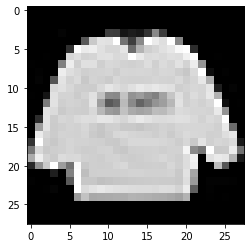

In [15]:
fig, ax = plt.subplots()
ax.imshow(image.squeeze(), cmap='gray');
print(f"Label: {label}")

Labels: tensor([2, 9, 6, 0, 3, 4, 4, 5, 4, 8, 0, 8, 9, 0, 2, 2, 9, 3, 3, 3, 8, 7, 4, 4,
        0, 4, 4, 8, 7, 1, 5, 0, 5, 3, 2, 7, 3, 4, 2, 1, 6, 0, 9, 6, 0, 5, 6, 7,
        7, 2, 5, 2, 2, 4, 1, 4, 9, 8, 3, 4, 5, 5, 6, 3, 5, 8, 5, 9, 8, 1, 2, 8,
        1, 3, 6, 8, 3, 4, 2, 5, 0, 2, 6, 8, 1, 2, 7, 6, 6, 4, 6, 5, 0, 1, 7, 3,
        5, 8, 4, 3, 8, 5, 0, 5, 3, 0, 8, 5, 6, 1, 0, 7, 6, 1, 9, 7, 6, 9, 3, 3,
        2, 6, 0, 6, 3, 6, 3, 5])


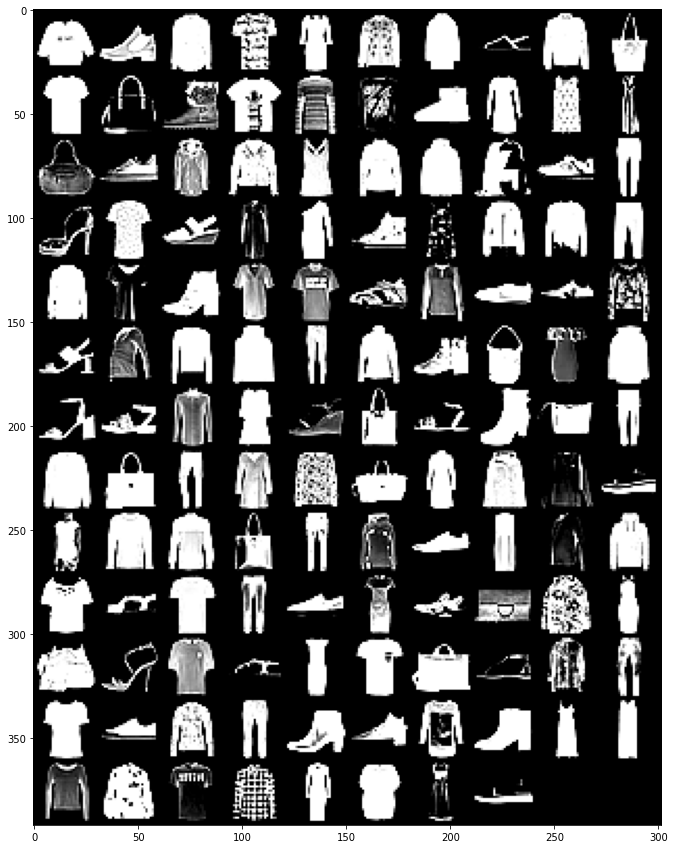

In [16]:
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images, nrow=10)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.transpose(grid, (1,2,0)))

print(f"Labels: {labels}")

In [17]:
test_set = MnistCustomDataset(csv_file="/content/drive/MyDrive/Deep-Learning-Revision/mnist_dataset/fashion_mnist/fashion-mnist_test.csv",
                               transform = transformations)

In [18]:
test_loader = DataLoader(test_set, batch_size = 512)

In [74]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features = 12*4*4, out_features = 128)
    self.fc2 = nn.Linear(in_features = 128, out_features = 64)
    self.out = nn.Linear(in_features = 64, out_features = 10)

  def forward(self, t):
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = t.reshape(-1, 12*4*4)

    t = self.fc1(t)
    t = F.relu(t)

    t = self.fc2(t)
    t = F.relu(t)

    t = self.out(t)

    return t

In [75]:
model = Model()

In [76]:
model.to(device)

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [77]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [78]:
def get_num_correct(preds, targets):
  return preds.argmax(dim=1).eq(targets).sum().item()

In [79]:
n_epochs = 2

for epoch in range(n_epochs):
  total_loss = 0
  total_correct = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    preds = model(images)
    loss = F.cross_entropy(preds, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
  print(f"Epoch: {epoch + 1}\t total_correct: {total_correct}\t Loss: {total_loss:.4f}")


Epoch: 1	 total_correct: 47213	 Loss: 273.2565
Epoch: 2	 total_correct: 51701	 Loss: 178.2101


In [80]:
@torch.no_grad()
def get_all_preds(model, data_loader):
  all_preds = torch.Tensor([]).to(device)
  for images, _ in data_loader:
    images = images.to(device)
    preds = model(images)
    all_preds = torch.cat((all_preds, preds), dim=0)
  print(preds.shape)
  print(all_preds.shape)
  return all_preds


In [81]:
prediction_loader = DataLoader(train_set, batch_size=1000)
train_preds = get_all_preds(model, prediction_loader)

torch.Size([1000, 10])
torch.Size([60000, 10])


In [82]:
train_preds.argmax(dim=1).shape


torch.Size([60000])

In [83]:
train_set.targets.shape

torch.Size([60000])

In [84]:
# Creating a confusion matrix manually

conf_mat = np.zeros((10,10), dtype=np.int32)
conf_mat

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [87]:
stacked = torch.stack((train_set.targets.to(device), train_preds.argmax(dim=1)), dim=1)

In [89]:
for true_label, pred in stacked.tolist():
  conf_mat[true_label][pred] += 1
conf_mat

array([[4968,    4,  115,  428,   45,    5,  384,    0,   50,    1],
       [   1, 5827,    3,  125,   21,    1,   16,    0,    6,    0],
       [  62,    2, 4908,   94,  704,    3,  206,    0,   21,    0],
       [  71,   25,   26, 5534,  260,    1,   60,    0,   23,    0],
       [   5,    6,  365,  217, 5247,    0,  150,    0,   10,    0],
       [   2,    1,    0,    5,    0, 5768,    0,  142,   22,   60],
       [ 935,    8,  628,  267, 1013,    1, 3092,    0,   56,    0],
       [   0,    0,    0,    0,    0,  117,    0, 5672,    7,  204],
       [  13,    4,   24,   22,   42,   11,   59,    8, 5813,    4],
       [   0,    0,    0,    1,    0,   45,    1,  168,    6, 5779]],
      dtype=int32)

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [98]:
# Creating a confusion matrix using a library

conf_mat = confusion_matrix(train_set.targets, train_preds.argmax(dim=1).tolist())
conf_mat

array([[4968,    4,  115,  428,   45,    5,  384,    0,   50,    1],
       [   1, 5827,    3,  125,   21,    1,   16,    0,    6,    0],
       [  62,    2, 4908,   94,  704,    3,  206,    0,   21,    0],
       [  71,   25,   26, 5534,  260,    1,   60,    0,   23,    0],
       [   5,    6,  365,  217, 5247,    0,  150,    0,   10,    0],
       [   2,    1,    0,    5,    0, 5768,    0,  142,   22,   60],
       [ 935,    8,  628,  267, 1013,    1, 3092,    0,   56,    0],
       [   0,    0,    0,    0,    0,  117,    0, 5672,    7,  204],
       [  13,    4,   24,   22,   42,   11,   59,    8, 5813,    4],
       [   0,    0,    0,    1,    0,   45,    1,  168,    6, 5779]])

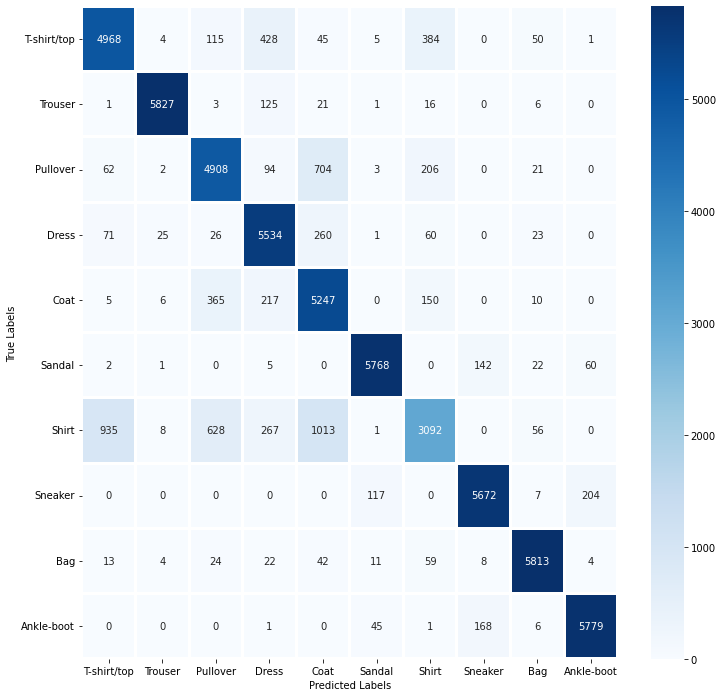

In [128]:
names = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle-boot")
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(conf_mat, annot=True, fmt='.0f', cbar=1, linewidths=2, cmap='Blues')
fig.set_label("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_xticklabels(names)
ax.set_yticklabels(names, rotation=0)
plt.show()